First, load the data,in this notebook we are using the Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". The data has been preprocessed in R (refer to the r script in iCloud/UTK/GRA-UTK/SelectMicro/MLonMicrobiome).

There are 3 datasets, the orginal paper combined the 3 datasets together, but not sure how they are combined since they have different columns. The imbalance is an issue if analyzing each dataset independently.

In [1]:
import sys
sys.path.append('./Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle

In [2]:
qitta_combine = pd.read_csv('./Data/Qitta_3datasetscombined.csv',index_col=0)

In [3]:
print(qitta_combine.shape)

(1569, 3836)


In [4]:
print(qitta_combine)

               Diagnosis  X4454356  X261920  X4474844  X301062  X4455330  \
11484.CSM5FZ3X        CD         0        0         0        0         0   
11484.CSM5FZ3Z        CD         0        0         0        1         0   
11484.MSM5LLIQ        UC         0        0         1        0         0   
11484.CSM5FZ3N        CD         0        0         1        0         0   
11484.CSM5MCV5        CD         1        0         0        0         0   
...                  ...       ...      ...       ...      ...       ...   
2151.G10483       nonIBD         0        0         0        0         0   
2151.G11579       nonIBD         0        0         0        0         0   
2151.G11295       nonIBD         0        0         0        0         0   
2151.G11157       nonIBD         0        0         0        0         0   
2151.G10686       nonIBD         0        0         0        0         0   

                X3957916  X2506486  X300250  X4343580  ...  X310490  X310492  \
11484.C

Extract OTU table and response variable

In [7]:
data = qitta_combine.drop(qitta_combine.columns[0], axis=1)
data = data.values

In [11]:
print(data)
print(np.shape(data))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1569, 3835)


In [12]:
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
y = qitta_combine.iloc[:, 0].values 

In [15]:
set(y)

{'CD', 'UC', 'nonIBD'}

In [16]:
#change y into 2 levels
y = np.where(np.isin(y, ['CD', 'UC']), 'IBD', y)

In [17]:
y

array(['IBD', 'IBD', 'IBD', ..., 'nonIBD', 'nonIBD', 'nonIBD'],
      dtype=object)

In [37]:
# y is an array and y_lable is an series(pd.DataFrame)
y_lable = pd.DataFrame(y)
y_lable.value_counts()

nonIBD    867
IBD       702
dtype: int64

preprocess the OTU table

In [18]:
data=RunML.normalizingMatrixToRanks(data,cutOff=0.01)
print(np.shape(data))

(1569, 3835)


Perform sigle lable feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

In [22]:
weights=FS.singleLabelFeatureWeighting(data,y)

In [23]:
len(weights)

3835

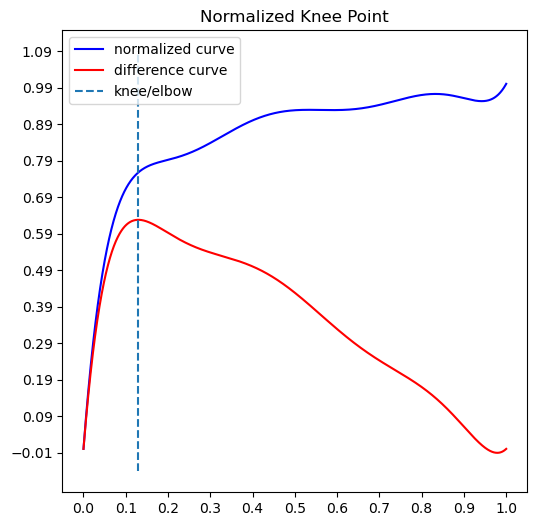

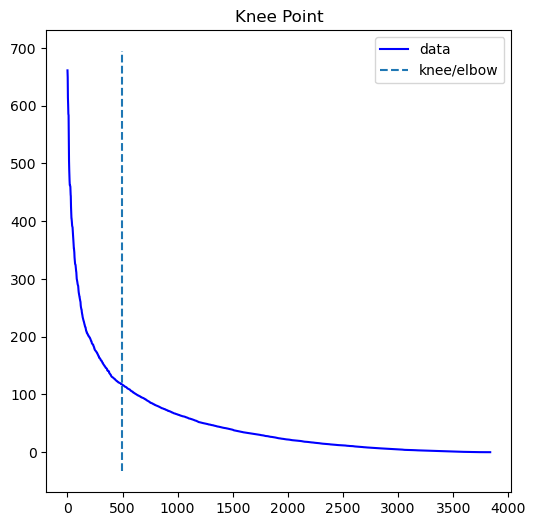

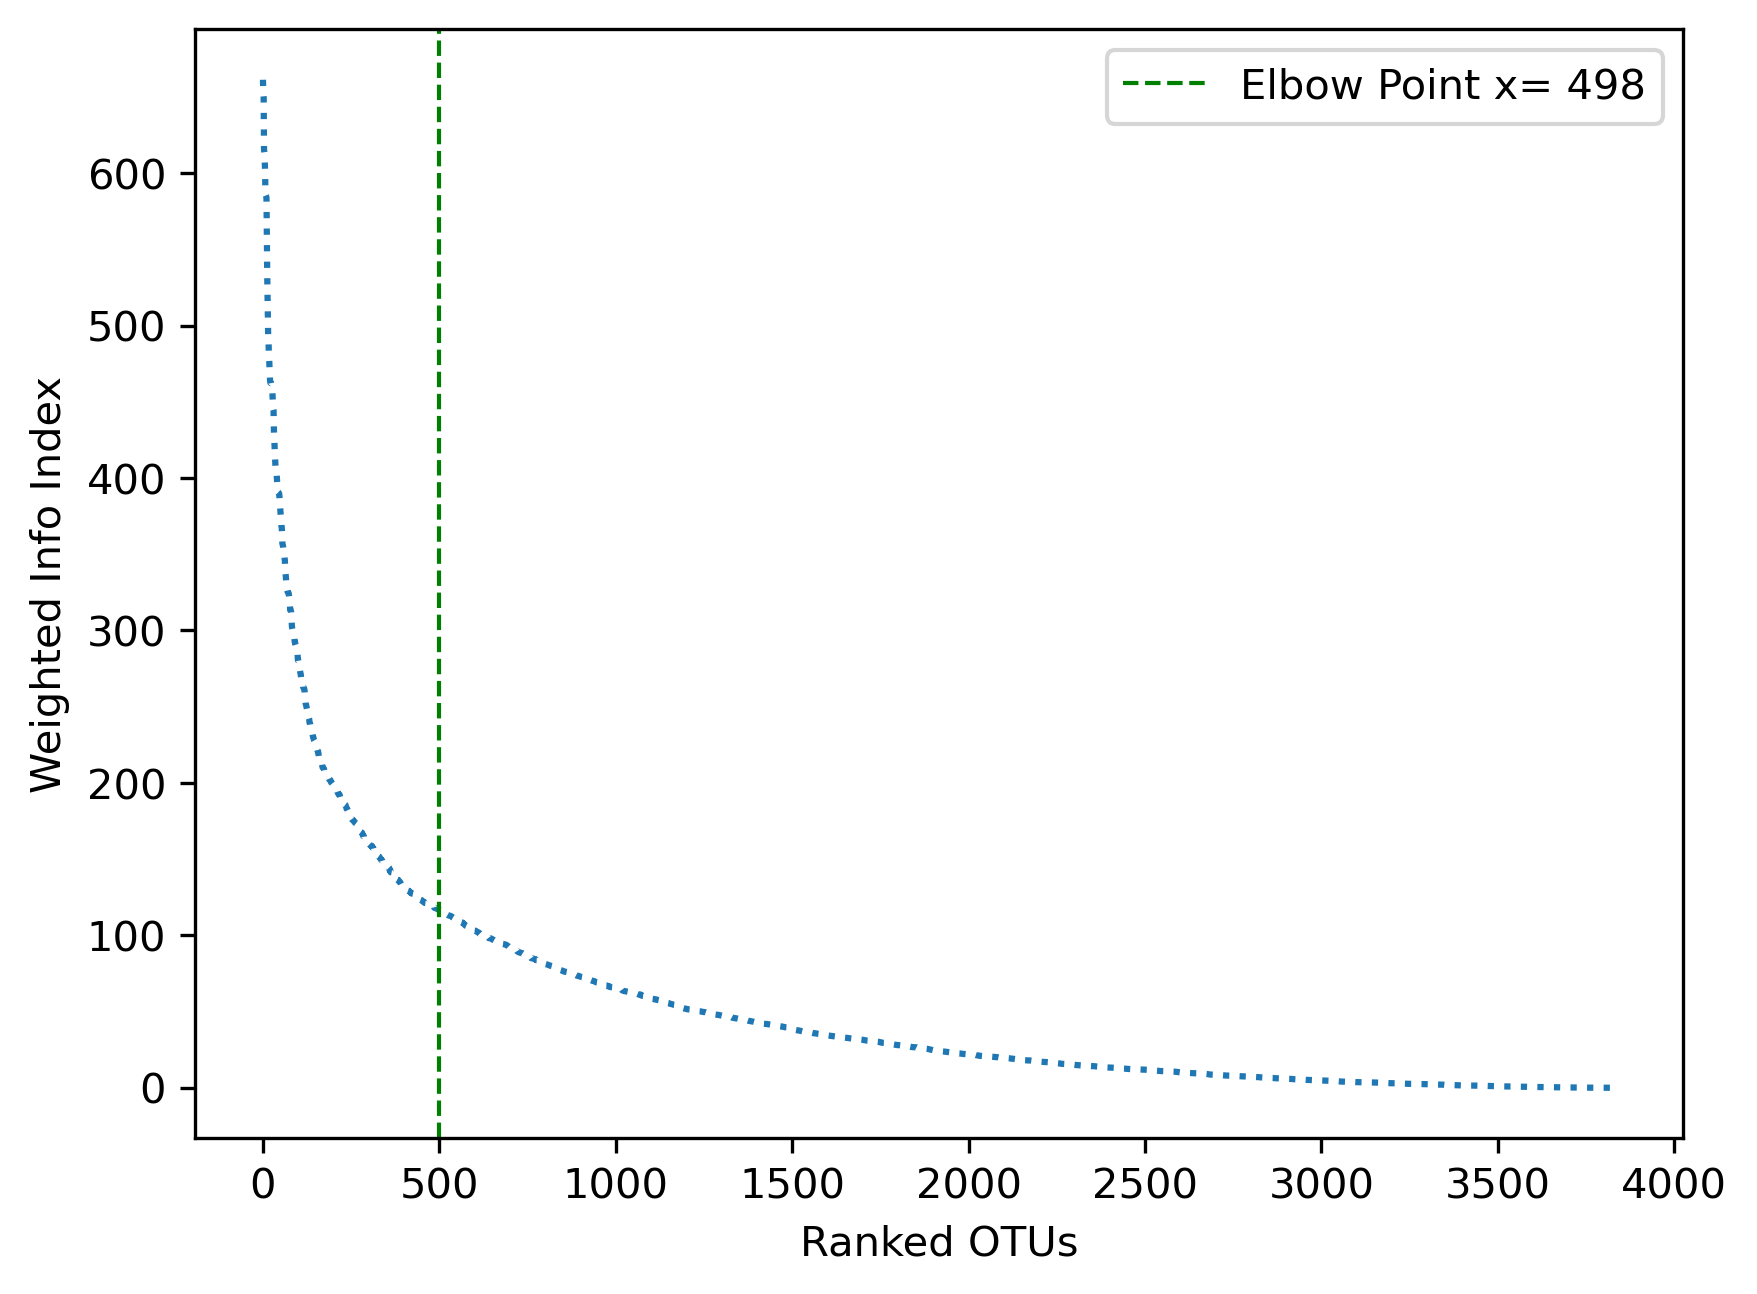

In [24]:
scores=(sorted(weights,reverse=True))
eps=FS.elbowPoint(scores)
FS.plotWeightedIndex(weights,xKnee=eps)

This plot shows that the gain in information decreases as we include more OTUs along the ranks. 

In [27]:
topFeature_selected=eps
print(eps)

X_FS,selectedOTU_index=FS.feature_select_singleLabel(data,y,topFeature=topFeature_selected)
print (np.shape(X_FS))


498
(1569, 498)


In [28]:
print(len(weights))

3835


Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method, repeat the  process iter=20 times to  find the mean accuracy and AUC)---> use random forest and SVM as classifier

In [34]:
iter =10
cls = ["RF","SVM"]

In [38]:
np.shape(y)

(1569,)

In [39]:
targetLabel=y
X_lasso = RunML.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }


started modeling, the  function will print out the accuracy and AUC for each dataset using each classifier. and also will return the y_actual, y_predict, y_predprob

In [41]:
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.952185  0.990480      0.942012  0.987025
SelectMicro     0.941346  0.987673      0.913303  0.974866
Lasso           0.955371  0.990692      0.948383  0.987814
Random          0.943898  0.985796      0.902157  0.962643


In [42]:
# Save dictionary to a pickle file
with open('results/dict_cm_qitta.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm, pickle_file)

In [43]:
# Load dictionary from the pickle file
with open('results/dict_cm_qitta.pkl', 'rb') as pickle_file:
    dict_cm = pickle.load(pickle_file)

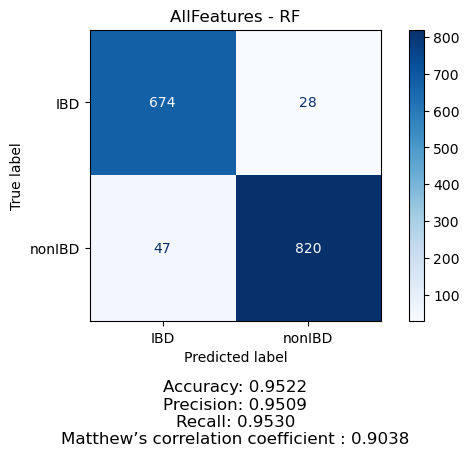

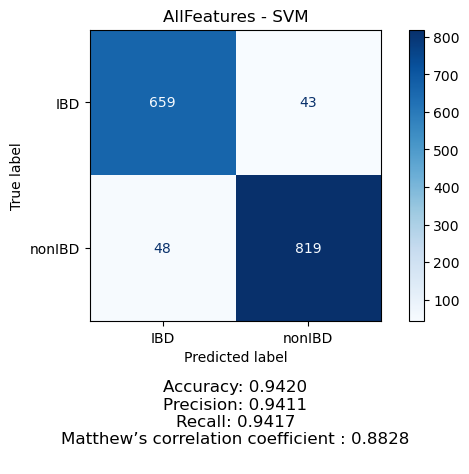

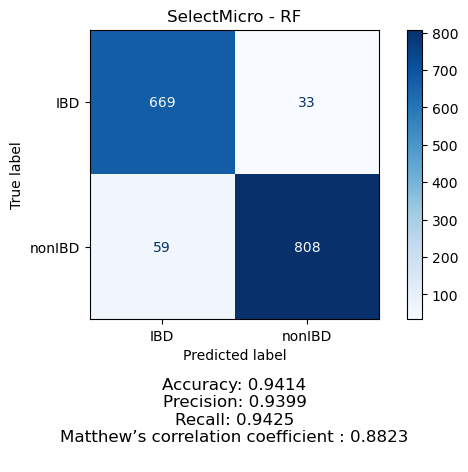

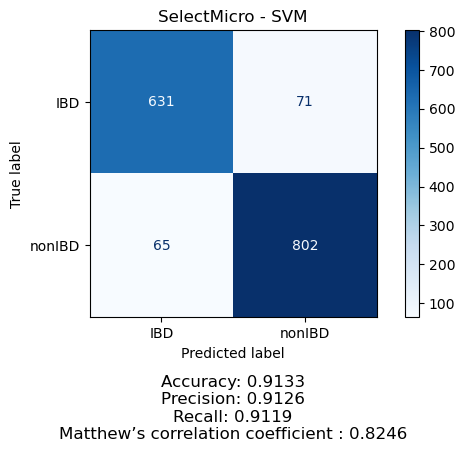

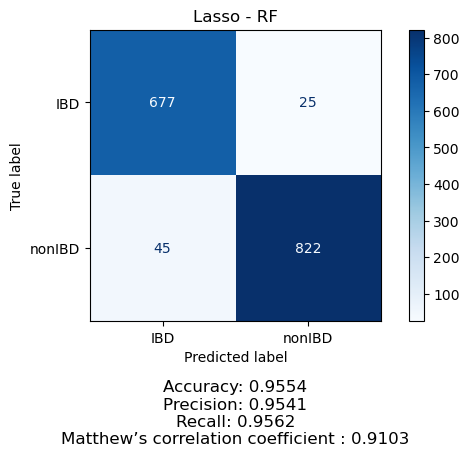

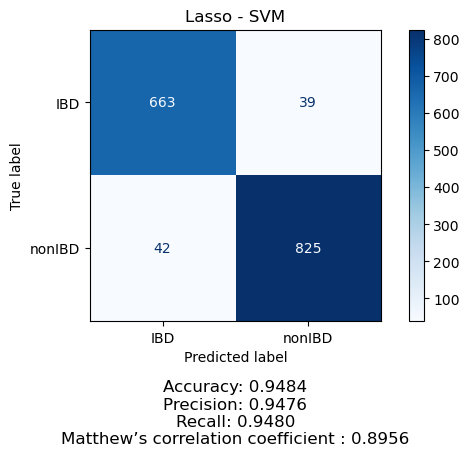

In [44]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

## compare the first 15 index

In [45]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]

df=pd.DataFrame(data=X_FS_15)
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]


NameError: name 'ASVs' is not defined

In [ ]:
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="IBD",posText="IBD",negText="nonIBD",entries=entries)